# <center>NICE [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

**Additive coupling layer:** Let $d=\frac{D}{2}$,
\begin{equation*}
    \begin{cases}
        z'_{1:d} = z_{1:d} \\
        z'_{d+1:D} = z_{d+1:D}+m(z_{1:d})
    \end{cases}
\end{equation*}

with $m$ a neural network.

For inverting, we got:
\begin{equation*}
    \begin{cases}
        z_{1:d} = z'_{1:d} \\
        z_{d+1:D} = z'_{d+1:D}-m(z'_{1:d})
    \end{cases}
\end{equation*}

And $\det J_T(z) = 1$.

**Scaling Layer:**
\begin{equation*}
    z' = \exp(s)\odot z
\end{equation*}

## Moons

In [4]:
def train_moons(model, n_epochs=10001):
    d = 2
#     base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
#         torch.zeros(d,device=device),torch.eye(d,device=device))
    
    base_distr = TransformedDistribution(Uniform(torch.zeros(d, device=device),
                                       torch.ones(d, device=device)),
                                   SigmoidTransform().inv)

    train_loss = []

    for i in range(n_epochs):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            print(i,train_loss[-1])

        if (i + 1) % 500 == 0:
            model.eval()

            xline = torch.linspace(-1.5, 2.5)
            yline = torch.linspace(-.75, 1.25)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                xy, log_s = model(xyinput.to(device))
                zz = (log_likelihood(xy[-1],log_s)).exp().cpu()
                zgrid = zz.reshape(100,100)


                z = base_distr.sample((100,))
                xs, _ = model.backward(z)
                x = xs[-1].detach()
                x = x.cpu().numpy()
                z = z.cpu().numpy()

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.colorbar()
            plt.scatter(x[:,0],x[:,1],c="red")
            plt.scatter(z[:,0],z[:,1],c="green")
            plt.xlim(-1.5,2.5)
            plt.ylim(-0.75,1.25)
            plt.title('iteration {}'.format(i + 1))
            plt.show()
            
    return train_loss

In [5]:
def loss(h,log_det,d=2):
#     base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
#         torch.zeros(d,device=device),torch.eye(d,device=device))
    
    base_distr = TransformedDistribution(Uniform(torch.zeros(d, device=device),
                                         torch.ones(d, device=device)),
                                         SigmoidTransform().inv)

    prior = base_distr.log_prob(h).sum(1).mean(0)
    return -(prior+log_det.mean())

def log_likelihood(h,log_det,d=2):
#     base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
#         torch.zeros(d,device=device),torch.eye(d,device=device))
    
    base_distr = TransformedDistribution(Uniform(torch.zeros(d, device=device),
                                         torch.ones(d, device=device)),
                                         SigmoidTransform().inv)

    prior = base_distr.log_prob(h).sum(1)
    return prior+log_det

In [6]:
d = 2

couplings = [shifting(d//2,24,d//2,3) for k in range(4)]

flows = []
for i in range(4):
    flows.append(AdditiveCoupling(couplings[i],d))
    flows.append(Reverse(d))
flows.append(Scale(d))

model = NormalizingFlows(flows).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  7494


0 2.7261786460876465
100 2.6495606899261475
200 2.6217586994171143
300 2.4774441719055176
400 2.3780226707458496


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)


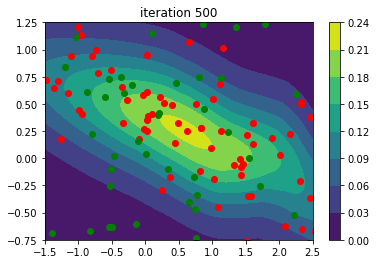

500 2.3460693359375
600 2.253981590270996
700 2.1495232582092285
800 2.1362409591674805
900 2.1269400119781494


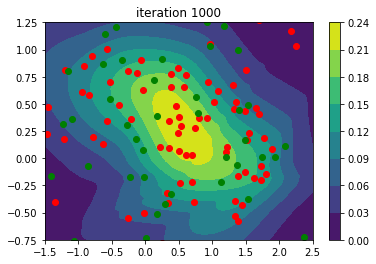

1000 2.1011533737182617
1100 2.0909485816955566
1200 2.033524990081787
1300 2.0188283920288086
1400 1.990936517715454


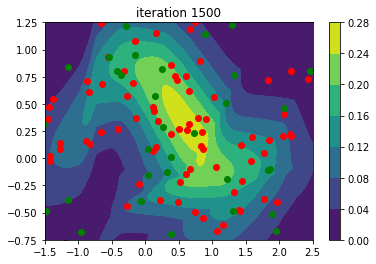

1500 1.9732913970947266
1600 1.958957314491272
1700 1.9744187593460083
1800 1.9178097248077393
1900 1.9185633659362793


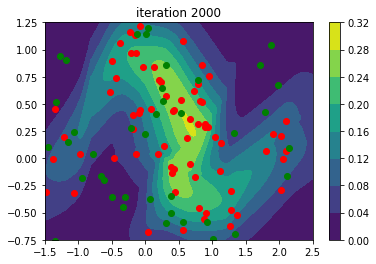

2000 1.8611512184143066
2100 1.8707640171051025
2200 1.8483095169067383
2300 1.8034688234329224
2400 1.7521014213562012


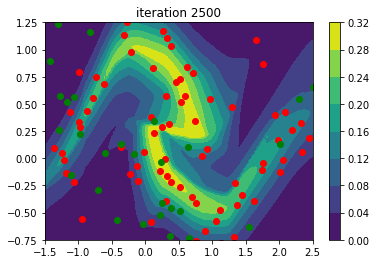

2500 1.7315800189971924
2600 1.6834070682525635
2700 1.6515461206436157
2800 1.67819344997406
2900 1.5924755334854126


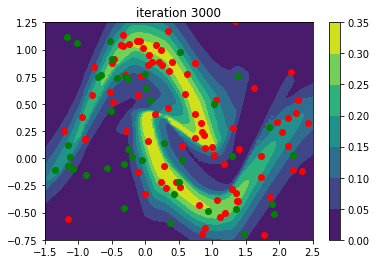

3000 1.5878344774246216
3100 1.6138551235198975
3200 1.6587460041046143
3300 1.6815390586853027
3400 1.5895278453826904


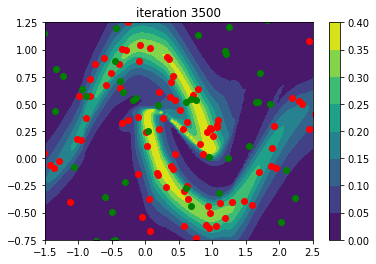

3500 1.6354246139526367
3600 1.600890874862671
3700 1.5517642498016357
3800 1.537737250328064
3900 1.542659878730774


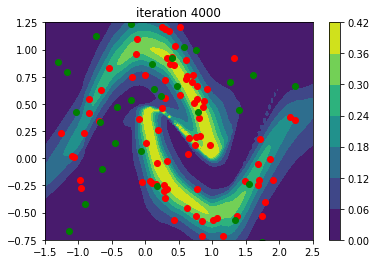

4000 1.4835662841796875
4100 1.5645956993103027
4200 1.5299917459487915
4300 1.4875538349151611
4400 1.5493627786636353


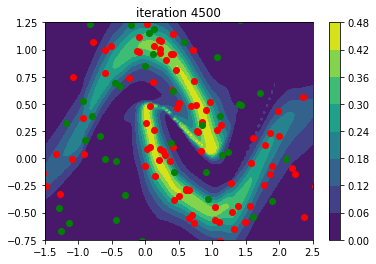

4500 1.50521719455719
4600 1.5215890407562256
4700 1.4703953266143799
4800 1.4366741180419922
4900 1.4340403079986572


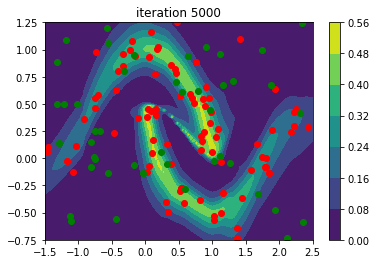

5000 1.4850752353668213
5100 1.3834021091461182
5200 1.463620901107788
5300 1.434138298034668
5400 1.481851577758789


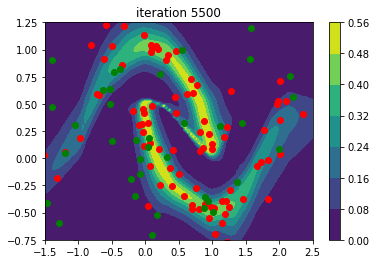

5500 1.3951778411865234
5600 1.3378236293792725
5700 1.4089233875274658
5800 1.4628496170043945
5900 1.2960069179534912


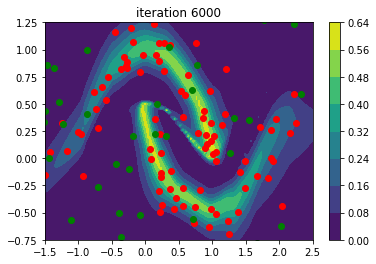

6000 1.3963713645935059
6100 1.4157383441925049
6200 1.2463328838348389
6300 1.276416540145874
6400 1.456453561782837


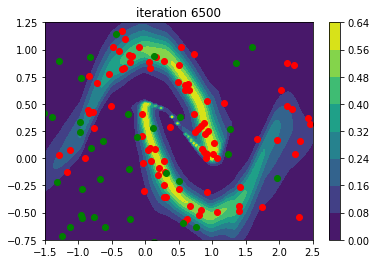

6500 1.326735019683838
6600 1.2961969375610352
6700 1.3081262111663818
6800 1.421574354171753
6900 1.221465826034546


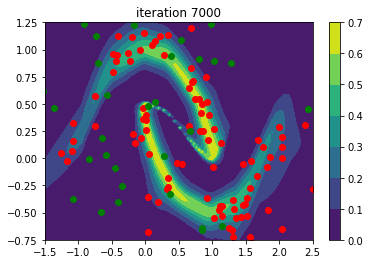

7000 1.2722370624542236
7100 1.2751586437225342
7200 1.3346316814422607
7300 1.2687466144561768
7400 1.2300031185150146


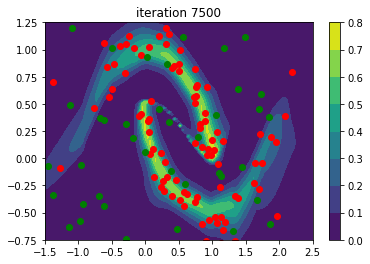

7500 1.348832368850708
7600 1.3091440200805664
7700 1.2458293437957764
7800 1.3200054168701172
7900 1.4035568237304688


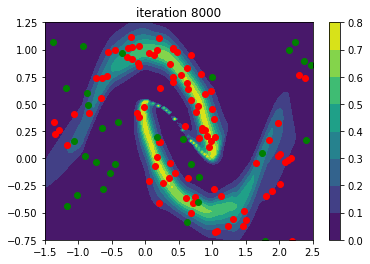

8000 1.4643065929412842
8100 1.385436773300171
8200 1.331336259841919
8300 1.266115665435791
8400 1.308239221572876


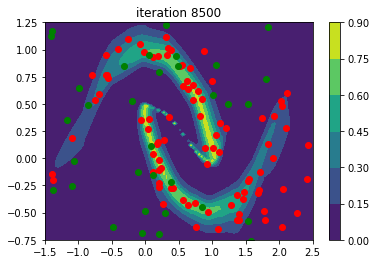

8500 1.324169397354126
8600 1.2837855815887451
8700 1.2731893062591553
8800 1.250488519668579
8900 1.479619026184082


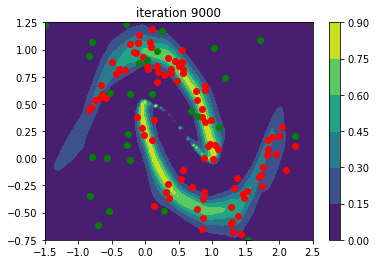

9000 1.3562297821044922
9100 1.183006763458252
9200 1.1604678630828857
9300 1.213505744934082
9400 1.189737319946289


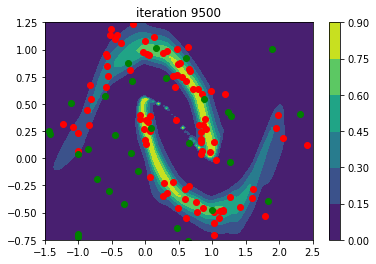

9500 1.2680480480194092
9600 1.2023169994354248
9700 1.3906068801879883
9800 1.323030710220337
9900 1.2179450988769531


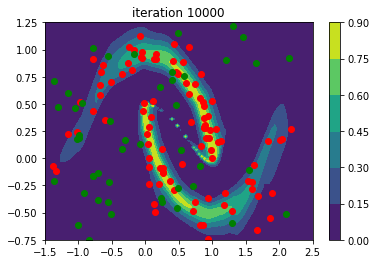

10000 1.2613563537597656


In [7]:
train_loss = train_moons(model, n_epochs=10001)

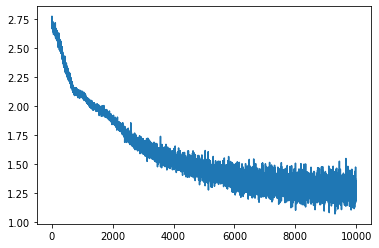

In [8]:
plt.plot(train_loss)
plt.show()

## References

<a id="reference1"></a>

[1] Dinh, L., Krueger, D., & Bengio, Y.Nice: Non-linear independent components estimation. arXiv preprint 	arXiv:1410.8516 . (2017). [link](https://arxiv.org/pdf/1410.8516.pdf)